In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Jupyter/Colab-specific (optional)
%matplotlib inline
sns.set(style="whitegrid")


In [3]:

df = sns.load_dataset('iris')
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
# 3. Quick EDA
df.info()
df.describe()
df['species'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

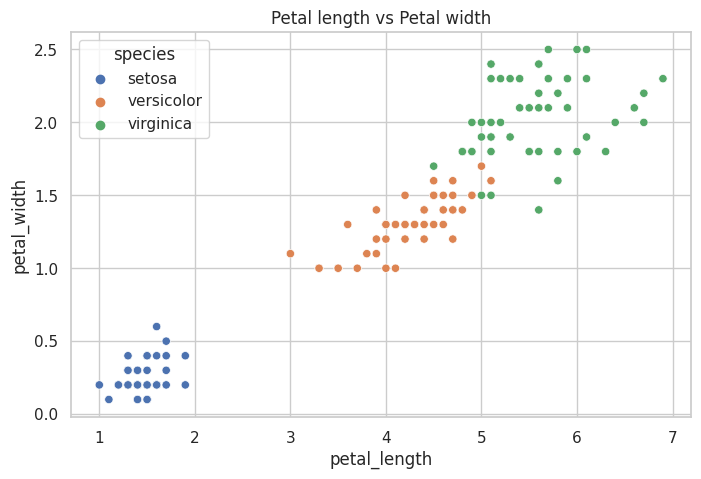

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

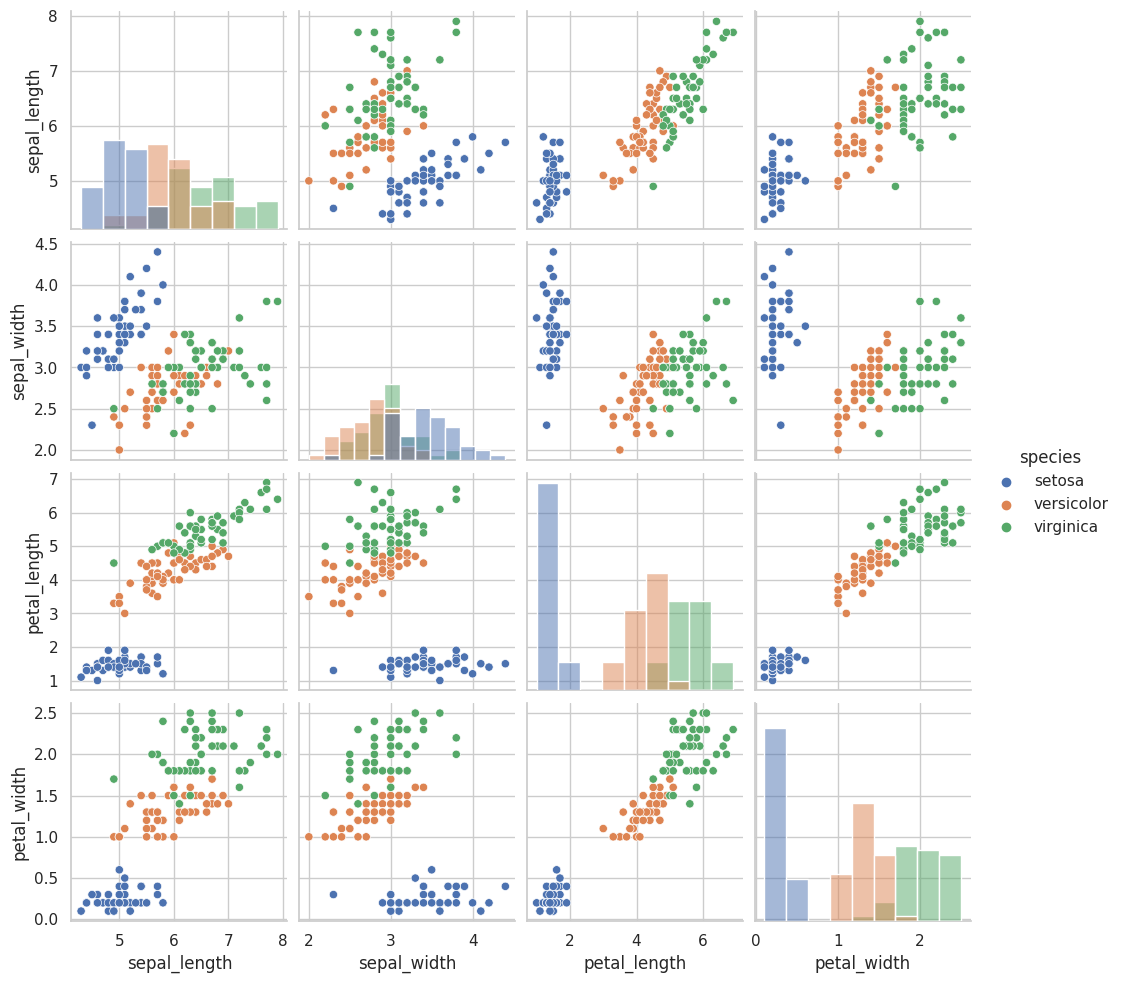

In [5]:
# 4. Visualizations (important to understand data)
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='petal_length', y='petal_width', hue='species')
plt.title('Petal length vs Petal width')
plt.show()

# Pairplot (shows pairwise relations)
sns.pairplot(df, hue='species', diag_kind='hist')


In [6]:
# 5. Prepare features and labels
X = df.drop(columns=['species'])
y = df['species']

# Encode labels to numbers
le = LabelEncoder()
y_enc = le.fit_transform(y)   # setosa->0, versicolor->1, virginica->2

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)


In [7]:
# 6. Feature scaling (especially for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Logistic Regression Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



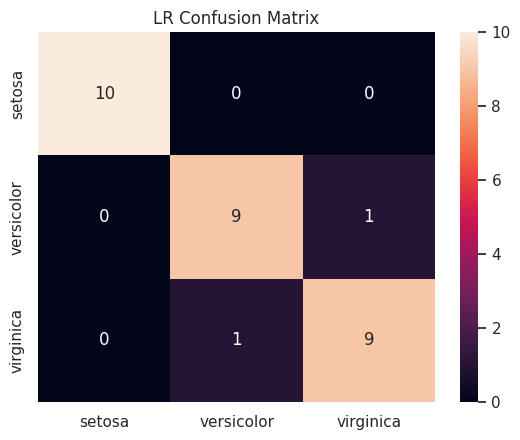

In [8]:
# 7. Model 1: Logistic Regression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LR Confusion Matrix')
plt.show()


In [9]:
# 8. Model 2: K-Nearest Neighbors (with simple hyperparameter tuning)
params = {'n_neighbors': list(range(1,16))}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid=params, cv=5)
grid.fit(X_train_scaled, y_train)

best_knn = grid.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)

print("Best K for KNN:", grid.best_params_)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))


Best K for KNN: {'n_neighbors': 5}
KNN Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [11]:
# 9. Model 3: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)   # RandomForest doesn't strictly need scaled features
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))



Random Forest Accuracy: 0.9
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



In [12]:
# 10. Compare model accuracies
from prettytable import PrettyTable
t = PrettyTable(['Model', 'Accuracy'])
t.add_row(['Logistic Regression', round(accuracy_score(y_test, y_pred_lr), 4)])
t.add_row(['KNN (best)', round(accuracy_score(y_test, y_pred_knn), 4)])
t.add_row(['Random Forest', round(accuracy_score(y_test, y_pred_rf), 4)])
print(t)


+---------------------+----------+
|        Model        | Accuracy |
+---------------------+----------+
| Logistic Regression |  0.9333  |
|      KNN (best)     |  0.9333  |
|    Random Forest    |   0.9    |
+---------------------+----------+


In [13]:
# 11. Save the best model + scaler + label encoder (example: if Random Forest best)
joblib.dump(rf, 'iris_rf_model.joblib')
joblib.dump(scaler, 'iris_scaler.joblib')
joblib.dump(le, 'iris_label_encoder.joblib')


['iris_label_encoder.joblib']

In [14]:
# 12. Example: Load model and predict on a new sample
model = joblib.load('iris_rf_model.joblib')
le2 = joblib.load('iris_label_encoder.joblib')

# New sample (sepal_length, sepal_width, petal_length, petal_width)
sample = np.array([[5.1, 3.5, 1.4, 0.2]])
pred = model.predict(sample)
print("Predicted label number:", pred)
print("Predicted species:", le2.inverse_transform(pred)[0])


Predicted label number: [0]
Predicted species: setosa


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
